In [1]:
from legal_backend.r_to_py.r_to_py import init_R
from legal_backend.bartCause.bart_cause import BARTCause
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.stats import permutation_test
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt

In [2]:
init_R()

### Infer Law Effect

In [3]:
#load csv files and load possible laws
laws_df = pd.read_csv('laws.csv')
opi_df = pd.read_csv('opioid2013.csv')

law_names = list(laws_df.columns)[1:]

In [4]:
# pick a law of interest
law = law_names[27]
print(law)

adult_law


In [5]:
# prepare a BART oriented dataframe 
merged_df = opi_df.merge(laws_df[['fips',law]], on=['fips'])
df_ = merged_df.drop(columns=['fips', 'state_name', 'county_name', 'death_rate_2013_2016'])
df_ = df_.rename(columns={'death_rate':'delta_death_rate'})
feat_cols = list(df_.columns)[:-2]
law = list(df_.columns)[-1]
delta_death = 'delta_death_rate'

new_cols = feat_cols + [law] + [delta_death]
df= df_[new_cols]
df.head()

,percent_of_population_under_15_(2013_2017),percent_of_population_aged_15_to_64_(2013_2017),percent_of_population_65plus_(2013_2017),percent_of_population_white_(non_hispanic)_(2013_2017),percent_of_populaiton_black_(non_hispanic)_(2013_2017),percent_of_population_hispanic_or_latino_(2013_2017),percent_of_population_asian_(non_hispanic)_(2013_2017),percent_of_population_native_american_alaska_native_(non_hispanic)_(2013_2017),percent_of_population_native_hawaiian_pacific_islander_(2013_2017),percent_of_population_aged_25plus_who_have_at_least_a_high_school_diploma_(2013_2017),...,number_of_mental_health_facilities_(as_of_march_2023),mdspercapita,urbanicity,social_resilience_score,economic_risk_score,social_risk_score,economic_resilience_score,prosperity_index_score,adult_law,delta_death_rate
0,0.2040,0.6562,0.1398,0.7568,0.1837,0.0257,0.0081,0.0041,0.0001,0.8758,...,0.0,3.63,1.0,4.0,2.0,2.0,5.0,3.0,0.0,-0.895509
1,0.1830,0.6298,0.1871,0.8318,0.0923,0.0437,0.0066,0.0062,0.0000,0.9003,...,1.0,7.52,1.0,3.0,1.0,2.0,2.0,2.0,0.0,21.770410
2,0.1794,0.6553,0.1653,0.4589,0.4789,0.0431,0.0044,0.0017,0.0000,0.7376,...,1.0,0.00,0.0,5.0,5.0,3.0,4.0,5.0,0.0,9.328918
3,0.1702,0.6809,0.1489,0.7477,0.2121,0.0222,0.0006,0.0036,0.0000,0.8070,...,0.0,8.86,1.0,4.0,4.0,4.0,3.0,4.0,0.0,18.037349
4,0.1942,0.6339,0.1719,0.8766,0.0156,0.0873,0.0016,0.0030,0.0000,0.8003,...,1.0,0.00,1.0,5.0,2.0,3.0,5.0,4.0,0.0,-25.060492


In [6]:
X_df = df.iloc[:, :27].to_numpy()
M = X_df.shape[1]  
# numerical columns
num_cols = [c for c in range(M) if len(np.unique(X_df[:, c])) > 2] 



# standardize data
scaler = preprocessing.StandardScaler().fit(X_df[:,num_cols])
X_scaled = np.copy(X_df)
X_scaled[:,num_cols] = scaler.transform(X_df[:,num_cols])

y = df[['delta_death_rate']].to_numpy()
Z_law = df[[law]].to_numpy()

In [7]:
bartCause = BARTCause()

In [8]:
bartCause.fit(X_scaled, y, Z_law)

In [9]:
ite = bartCause.fitted()

In [10]:
law0_idxs = list(df[df_[law]==0].index)
law1_idxs = list(df[df_[law]==1].index)

In [11]:
mean_law0 = ite[law0_idxs].mean()
mean_law1 = ite[law1_idxs].mean()

In [12]:
# prepare for permutation test
def statistic(x, y):
    return np.mean(x) - np.mean(y)

In [13]:
res = permutation_test((ite[law0_idxs], ite[law1_idxs]), statistic, alternative='less')

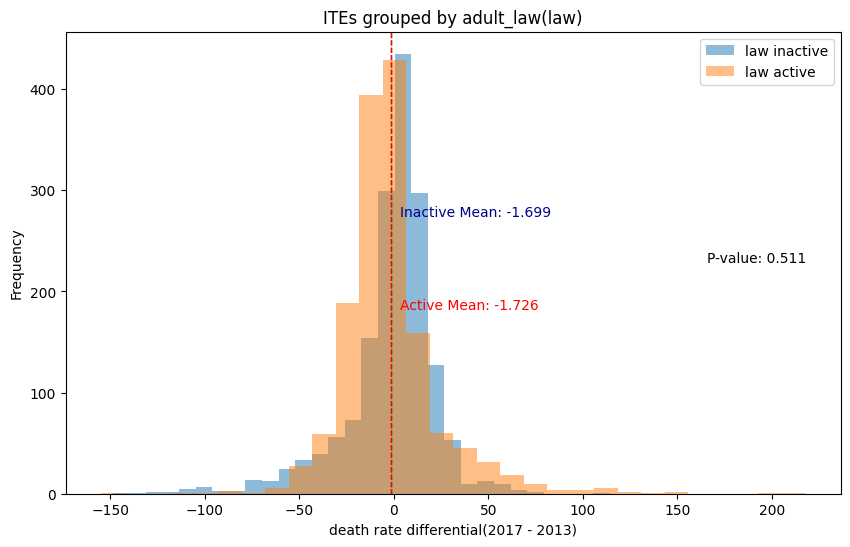

In [14]:

plt.figure(figsize=(10, 6))
plt.hist(ite[law0_idxs], bins=30, alpha=0.5, label='law inactive')
plt.hist(ite[law1_idxs], bins=30, alpha=0.5, label='law active')

plt.axvline(mean_law0, color='green', linestyle='dashed', linewidth=1)
plt.text(mean_law0 + 5, plt.ylim()[1] * 0.6, f'Inactive Mean: {mean_law0:.3f}', color='darkblue')
plt.axvline(mean_law1, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_law1 + 5, plt.ylim()[1] * 0.4, f'Active Mean: {mean_law1:.3f}', color='red')

plt.text(plt.xlim()[1]*0.7, plt.ylim()[1] * 0.5, f'P-value: {res.pvalue:.3f}', color='black')


plt.xlabel('death rate differential(2017 - 2013)')
plt.ylabel('Frequency')
plt.title('ITEs grouped by '+ law+'(law)')
plt.legend()
# plt.savefig("res/law_"+law+"_ite_grouped.png")
plt.show()

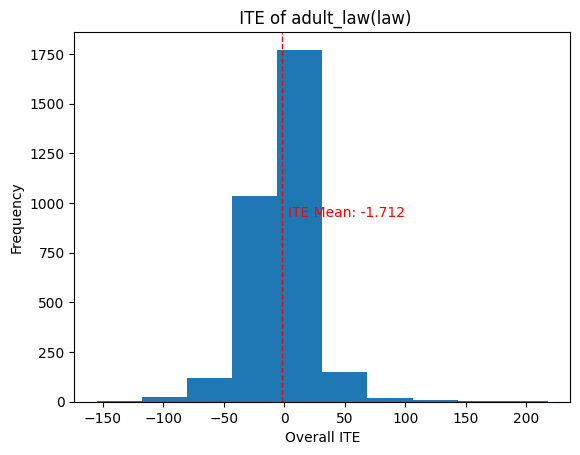

In [15]:
ite_mean = ite.mean()
plt.hist(ite)
plt.axvline(ite_mean, color='red', linestyle='dashed', linewidth=1)
plt.text(ite_mean + 5, plt.ylim()[1] / 2, f'ITE Mean: {ite_mean:.3f}', color='red')
plt.xlabel('Overall ITE')
plt.ylabel('Frequency')
plt.title(" ITE of "+ law + "(law)")
# plt.savefig("res/law_"+law+"_ite.png")
plt.show()

### Evaluate BART performance

In [16]:
# construct train test data 
train_idxs, test_idxs = train_test_split(list(df.index), test_size=0.3, random_state=99)


X_df = df.iloc[:, :27].to_numpy()
M = X_df.shape[1] 

y = df[['delta_death_rate']].to_numpy()
Z_law = df[[law]].to_numpy()
# numerical columns
num_cols = [c for c in range(M) if len(np.unique(X_df[:, c])) > 2] 


X_train = X_df[train_idxs,:]
X_test = X_df[test_idxs,:]

y_train = y[train_idxs,:]
y_test= y[test_idxs,:]

Z_train = Z_law[train_idxs,:]
Z_test= Z_law[test_idxs,:]

# standardize data
scaler_ = preprocessing.StandardScaler().fit(X_train[:,num_cols])
X_train_scaled = np.copy(X_train)
X_train_scaled[:,num_cols] = scaler_.transform(X_train[:,num_cols])

X_test_scaled = np.copy(X_test)
X_test_scaled[:,num_cols] = scaler_.transform(X_test[:,num_cols])


In [17]:
bart_eval = BARTCause()

In [18]:
bart_eval.fit(X_train_scaled, y_train, Z_train)

In [19]:
# evaluate treatment assignment accuracy
propensity_score_test = bart_eval.predict(X_test_scaled, infer_type="p.score")
treat_assign_predicted = np.where(propensity_score_test>0.5, 1, 0)

Z_test_predicted = treat_assign_predicted[:,np.newaxis]

# accuracy for treatment assignment
accuracy_score(Z_test_predicted, Z_test)

0.6634819532908705

In [20]:
def r_square(y, y_pred):
    # residual sum of squares
    ss_res = np.sum((y - y_pred) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [21]:
# evaluate BART fit on response surface
newData = np.concatenate((X_test_scaled, Z_test), axis=1)

y_test_predicted_ = bart_eval.predict(newData, infer_type="mu")
y_test_predicted = y_test_predicted_[:,np.newaxis]

r_square(y_test,y_test_predicted)

0.09132420219802528